

## **Loading Dataset from Drive**

In [0]:
from google.colab import drive,files
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "drive/My Drive/Dataset.zip" 
!ls



In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn
import cv2

**Function to Load Dataset into memory**

In [0]:
def loadDataset():
    dir = os.listdir('Dataset')
    X=[];
    y=[];

    for class_name in dir:

        files =os.listdir(os.path.join('Dataset',class_name))
        for f in files:
            if(f[-3:]=='png' or f[-3:]=='jpg'):
                X.append(os.path.join('Dataset',class_name,f))
                y.append(class_name)
                
    return pd.DataFrame({"path":X,"labels":y})


In [0]:
CLASSES=['handguns','razor blades','shurikens']

mapping={
    'handguns':0,
    'razor blades':1,
    'shurikens':2
   
}
NUM_CLASSES=len(CLASSES)

In [0]:
df=loadDataset()
print(df.head())
print(df['labels'].value_counts())

                                       path        labels
0  Dataset/razor blades/razor blades315.jpg  razor blades
1   Dataset/razor blades/razor blades18.jpg  razor blades
2  Dataset/razor blades/razor blades630.jpg  razor blades
3  Dataset/razor blades/razor blades632.jpg  razor blades
4  Dataset/razor blades/razor blades741.jpg  razor blades
shurikens       1000
razor blades    1000
handguns        1000
Name: labels, dtype: int64


### `Import required modules`

In [0]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn import svm

from keras.applications import ResNet50,MobileNet
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tensorflow.python.keras import backend as K
import keras.layers as layers
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D,Conv2D,Flatten,MaxPooling2D
import os
import keras
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [0]:
def loadModel():
    base_model = ResNet50(weights='imagenet', include_top=True)
 
    preds=base_model.layers[-2].output
    model = Model(inputs=base_model.input, outputs=preds)
    for layer in model.layers:
        layer.trainable = False
    return model


In [0]:
def extractHOGfeatures(img):
    resized_img = resize(img, (128 ,128,3)) 

    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
  
    return fd

def extractDeepFeatures(model,img_list,resize_factor=(224,224,3)):
    input_data=[]
    for img in img_list:
        resized_img = resize(img,resize_factor) 
        resized_img=preprocess_input(resized_img)
        input_data.append(resized_img)
 
    input_data= np.array(input_data)
    f=model.predict(input_data)
    return np.squeeze(f)

def createFeaturesDataset(df,model):
    features = []
    labels=[];
    for i in range(len(df)):
        img_path=df['path'][i]
        img = imread(img_path)
        f=extractDeepFeatures(model,[img])
        labels.append(df['labels'][i])
        features.append(f)
        print(np.array(features).shape)
    # features = np.array(features)
    # print(features.shape)
    return features,labels


In [0]:
model = loadModel()
model.summary()


In [0]:
features,labels=createFeaturesDataset(df,model)

**Saving  features in pkl file for future use**



In [0]:
import pickle

dic = {'features':features,"labels":labels}

pickle_out = open("deep_features.pickle","wb")
pickle.dump(dic, pickle_out)
pickle_out.close()
# save in gdrive

!zip -r "drive/My Drive/deep_features.zip" "deep_features.pickle"


  adding: deep_features.pickle (deflated 73%)


**Loading  features from pkl file stored earlier**



In [0]:
import pickle

!unzip "drive/My Drive/deep_features.zip" 


with open('deep_features.pickle', 'rb') as handle:
    dic = pickle.load(handle)
features = dic['features']
labels = dic['labels']



Archive:  drive/My Drive/deep_features.zip
  inflating: deep_features.pickle    


## SVM 

In [0]:
features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test  = train_test_split(features,labels, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)

clf = svm.LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)




(2700, 2048)
(300, 2048)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [0]:
clf.score(X_train,y_train)
clf.score(X_test,y_test)
predictions=clf.predict(features)

### *Inference section*

Total Accuracy : 67.87
Precision : [67.5795053  74.56140351 65.17719569]
Recall : [76.5 42.5 84.6]
Handguns Accuracy : 71.76
razor_blades Accuracy : 54.14
shurikens Accuracy : 73.63


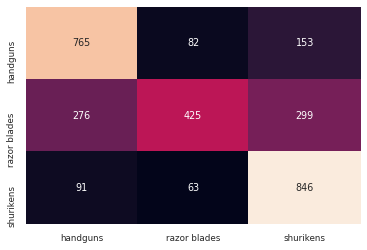

In [0]:
def plotConfusionMatrix(mat):

    # Normalise
    normalized_mat = mat.astype('float') /mat.sum(axis=1)[:, np.newaxis]


    df_cm = pd.DataFrame(mat,index=CLASSES,columns=CLASSES)
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=0.8)  # for label size
    sn.heatmap(df_cm, annot=True,fmt='d', cbar=False)  # font size

    plt.show()
truth=labels
accuracy = accuracy_score(truth,predictions)
confusion_mat=confusion_matrix(truth,predictions)
precsion, recall, f1_ccore, _ = precision_recall_fscore_support(truth, predictions)
print("Total Accuracy :",round(accuracy*100,2))
print("Precision :", (precsion*100))
print("Recall :",(recall*100))
print("Handguns Accuracy :", round(f1_ccore[0]*100,2))
print("razor_blades Accuracy :",round(f1_ccore[1]*100,2))
print("shurikens Accuracy :", round(f1_ccore[2]*100,2))

plotConfusionMatrix(confusion_mat)


['shurikens' 'shurikens' 'handguns' 'handguns']


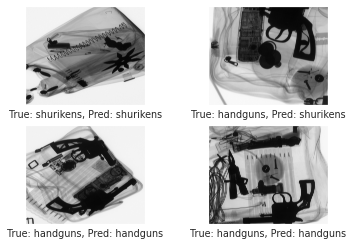

In [0]:
from math import sqrt
def plot_images(images, cls_true, cls_pred=None):

    # Create figure with 3x3 sub-plots.
    count = len(images)
    fig, axes = plt.subplots(int(sqrt(count)), int(sqrt(count)))
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i],cmap='gray')


        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def testRandom(clf,model,df,count =4):
    idx=np.random.randint(0,df.shape[0],count)
    file_path_list=list(df.loc[idx,'path'])
    true_labels =list(df.loc[idx,'labels'])

    feature_list =[];
    predicted_labels=[]
    img_list=[]
    for file_path in file_path_list:
      
        img = imread(file_path)
        img_list.append(img)
        f=extractDeepFeatures(model,[img])
        feature_list.append(f)

    predicted_labels=clf.predict(feature_list) 
    print(predicted_labels) 
    plot_images(img_list,true_labels,predicted_labels)

testRandom(clf,model,df)
   
